<a href="https://colab.research.google.com/github/felixsimard/comp551-p3/blob/main/Felix_Exploration_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [206]:
# Felix's Notebook #2 for exploring the assignment

In [207]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from PIL import Image
from sklearn import preprocessing
from tqdm import tqdm
import math
import string
import cv2
from google.colab.patches import cv2_imshow

In [208]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [209]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [210]:
def get_label_value(labels):
  """
  This function will return a string representing the label of a picture given
  the array label as input:
  Ex ouput: '1a', '4z' ...
  """
  label_temp = labels.tolist()
  label_temp = [int(x) for x in label_temp]
  number = label_temp[:10].index(1)
  letter = alpha_dict[label_temp[10:].index(1)]

  return str(number) + str(letter)

In [211]:
def transform_output(scores):
    """
    Input a Tensor and output will be another Tensor with same dimension but with all elements 0 except two.
    Those 2 elements will have value of 1 and will correspond to the models prediction about which letter and number
    is in the image.
    :param scores:
    :return:
    """
    return_array = []
    score_list = scores.tolist()

    for score in score_list:
        numbers = score[:10]
        letters = score[10:]
        test = lambda x, max_value : 1 if x >= max_value else 0

        new_numbers = [test(x, max(numbers)) for x in numbers]
        new_letters = [test(x, max(letters)) for x in letters]

        return_array.append(new_numbers + new_letters)

    return return_array

In [212]:
from google.colab import drive
drive.mount("/content/drive")
def load_data(filename, data_path='/content/drive/MyDrive/P3-COMP551-FALL2021/'):
    loaded_pkl = None
    try:
        pkl_buffered = open(data_path+''+filename,'rb')
        loaded_pkl = pickle.load(pkl_buffered)
    except Exception as e:
        print("Error loading data: {}".format(e))
    return loaded_pkl
    

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [213]:
# Load data
# make sure to add a dimension to loaded pickles to respect dimensions required by Conv2D layers
train_l = load_data("images_l.pkl")[:, None]
train_ul = load_data("images_ul.pkl")[:, None]
train_labels_l = load_data("labels_l.pkl")
test_ul = load_data("images_test.pkl")[:, None]

print("Train:", train_l.shape)
print("Test:", test_ul.shape)

Train: (30000, 1, 56, 56)
Test: (15000, 1, 56, 56)


In [251]:
# Reference: https://stackoverflow.com/questions/44429199/how-to-load-a-list-of-numpy-arrays-to-pytorch-dataset-loader
class CustomDataset(Dataset):
    def __init__(self, data, targets=None, transform=None, transform_target=None):
        self.data = torch.from_numpy(data).float().to(device)
        self.targets = torch.from_numpy(targets).float().to(device) if targets is not None else None
        self.transform = transform
        self.transform_target = transform_target
        
    def __getitem__(self, index):
        x = self.data[index]

        # Apply median-filtering to remove salt-pepper noise
        tmp = x.cpu().detach().numpy()
        tmp = np.squeeze(tmp, axis=0)

        img = Image.fromarray((tmp*255).astype(np.uint8))

        # # convert to gray
        # gray = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2GRAY)

        # # threshold 
        # mask = cv2.threshold(gray,0,255,cv2.THRESH_BINARY)[1]

        # # erode mask to make black regions slightly larger
        # kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
        # mask = cv2.morphologyEx(mask, cv2.MORPH_ERODE, kernel)


        # # make mask 3 channel
        # mask = cv2.merge([mask,mask,mask])

        # # invert mask
        # mask_inv = 255 - mask

        # # get area of largest contour
        # contours = cv2.findContours(mask_inv[:,:,0], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        # contours = contours[0] if len(contours) == 2 else contours[1]
        # perimeter_max = 0
        # for c in contours:
        #     perimeter = cv2.arcLength(c, True)
        #     if perimeter > perimeter_max:
        #         perimeter_max = perimeter

        # # approx radius from largest area
        # radius = int(perimeter_max/2) + 1
        # if radius % 2 == 0:
        #     radius = radius + 1
        # print(radius)

        # # median filter input image
        # median = cv2.medianBlur(img, radius)

        # # apply mask to image
        # img_masked = cv2.bitwise_and(img, mask)

        # # apply inverse mask to median
        # median_masked = cv2.bitwise_and(median, mask_inv)

        # # add together
        # result = cv2.add(img_masked,median_masked)

        # print(result, type(result))

        result = cv2.medianBlur(np.array(img), 3)


        x = torch.from_numpy(result).float().to(device)
        x = x.unsqueeze(0)

        y = np.zeros(36, dtype=float) # self.targets[index]

        if self.targets is not None:
            y = self.targets[index]
        else:
            None
        if self.transform:
            x = self.transform(x)
        if self.transform_target:
            y = self.transform_target(y)
        
        return x, y
    
    
    def __len__(self):
        return len(self.data)

In [252]:
# Hyper-parameters
NUM_EPOCHS = 5
BATCH_SIZE = 32
NUM_CHANNELS = 1
NUM_CLASSES = 36
LEARNING_RATE = 0.001
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0001
TRAIN_TEST_SPLIT = 0.1
FLATTEN_IMG_SIZE = 3136
PRODUCTION = False

In [253]:
# Tensor, Transform, Datasets, Dataloaders

# Split into training and validation
split_index = math.floor(len(train_labels_l)*TRAIN_TEST_SPLIT)

full_train_l = train_l
val_l = train_l[:split_index]
train_l = train_l[split_index:]

full_train_labels_l = train_labels_l
val_labels_l = train_labels_l[:split_index]
train_labels_l = train_labels_l[split_index:]

print("Full training:", full_train_l.shape, full_train_labels_l.shape)
print("Split Training:", train_l.shape, train_labels_l.shape)
print("Validation:", val_l.shape, val_labels_l.shape)

Full training: (17715, 1, 56, 56) (17715, 36)
Split Training: (15944, 1, 56, 56) (15944, 36)
Validation: (1771, 1, 56, 56) (1771, 36)


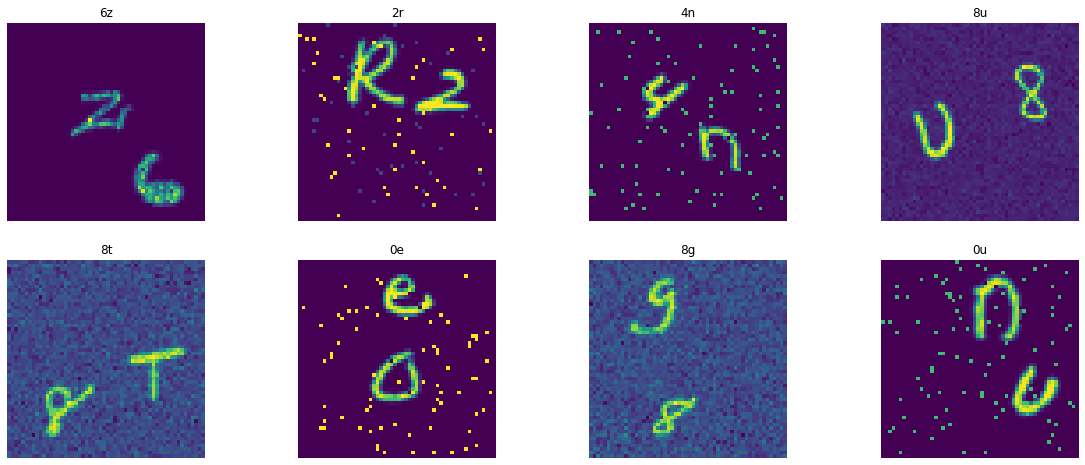

In [254]:
# Visualize some data
alpha_dict = dict(enumerate(string.ascii_lowercase))
figure = plt.figure(figsize=(20, 8))
cols, rows = 4, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_l), size=(1,)).item()
    img = train_l[sample_idx]
    label = get_label_value(train_labels_l[sample_idx])
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze())
plt.show()

In [255]:
# Turn data and labels into Datasets then DataLoaders

# Transform function
mean = (0.5,)
std = (0.5,)
transform = transforms.Compose(
    [transforms.Resize(56),
     transforms.Normalize(mean=mean, std=std)
     ])

# DataLoaders
full_train_l_dataloader = DataLoader(CustomDataset(full_train_l, full_train_labels_l, transform=transform), shuffle=True, batch_size=BATCH_SIZE)
train_l_dataloader = DataLoader(CustomDataset(train_l, train_labels_l, transform=transform), shuffle=True, batch_size=BATCH_SIZE)
val_l_dataloader = DataLoader(CustomDataset(val_l, val_labels_l, transform=transform), shuffle=True)

# Test set for Kaggle
test_labels_ul = np.zeros(len(test_ul))
test_ul_dataloader = DataLoader(CustomDataset(test_ul, test_labels_ul, transform=transform), batch_size=BATCH_SIZE, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


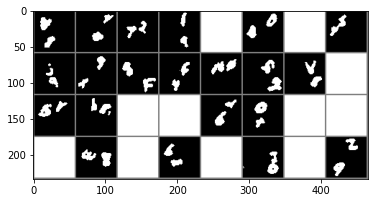

In [256]:
imgs, labels = next(iter(full_train_l_dataloader))


imshow(torchvision.utils.make_grid(imgs.cpu()))




In [220]:
# Implement CONV Net

# class ConvNet(nn.Module):
#     def __init__(self, input_size=FLATTEN_IMG_SIZE, in_channels=NUM_CHANNELS, num_classes=NUM_CLASSES):
#         super(ConvNet, self).__init__()
#         self.input_size = input_size
#         self.in_channels = in_channels
#         self.num_classes = num_classes
#         self.conv1 = nn.Conv2d(self.in_channels, 6, 5) # input channel (rgb), output channel, kernel size 
#         self.pool = nn.MaxPool2d(2, 2) # define 2x2 stride for max-pooling
#         self.conv2 = nn.Conv2d(6, 16, 5) # input channel size = output channel size of previous conv layer
#         self.fc1 = nn.Linear(16*11*11, 120) # fully connected layer
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, num_classes)   
#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x))) # activation function does not change size
#         x = self.pool(F.relu(self.conv2(x)))
#         x = x.view(-1, 16*11*11) # -1 tells PyTorch to infer num batches # flatten tensor
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x) # no activation at end, softmax included in CrossEntropyLoss
#         return x

# VGG11 Conv Net
class ConvNet_VGG11(nn.Module):
    def __init__(self, in_channels=NUM_CHANNELS, num_classes=NUM_CLASSES):
        super(ConvNet_VGG11, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        # convolution layers

        self.block1_conv1 = nn.Sequential(
            nn.Conv2d(self.in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.block2_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.block3_conv1 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.block4_conv1 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.block5_conv1 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=512, out_features=4096),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(in_features=4096, out_features=self.num_classes)
        )

    def forward(self, x):
        x = self.block1_conv1(x)
        x = self.block2_conv1(x)
        x = self.block3_conv1(x)
        x = self.block4_conv1(x)
        x = self.block5_conv1(x)
        # flatten to prepare for the fully connected layers
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

# ConvNet
class ConvNet(nn.Module):
    def __init__(self, in_channels=NUM_CHANNELS, num_classes=NUM_CLASSES):
        super().__init__() 
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(self.in_channels, 16, 3), # (b_sz, 1, 56, 56) --> (b_sz, 16, 54, 54)
            nn.MaxPool2d(3), # (b_sz, 16, 54, 54) --> (b_sz, 16, 18, 18)
            nn.ReLU()
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(16, 32, 3), # (b_sz, 16, 18, 18) --> (b_sz, 32, 16, 16)
            nn.MaxPool2d(2), # (b_sz, 32, 16, 16) --> (b_sz, 32, 8, 8)
            nn.ReLU()
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(32, 64, 3), # (b_sz, 32, 8, 8) --> (b_sz, 64, 6, 6)
            nn.MaxPool2d(2), # (b_sz, 64, 6, 6) --> (b_sz, 64, 3, 3)
            nn.ReLU()
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(64*3*3, 1024),
            nn.ReLU(),
            nn.Linear(1024, self.num_classes), 
        )
    
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = x.view(x.size()[0], -1)
        x = self.linear_layers(x)
        return x

model = ConvNet().to(device)

In [221]:
# Test model flow, check output size, shoudl be [batchs_size, num_classes]
dummy_model = ConvNet()
random_input = torch.rand(BATCH_SIZE, 1, 56, 56)
print(random_input.shape)
output = dummy_model(random_input)
print(output.shape)

torch.Size([32, 1, 56, 56])
torch.Size([32, 36])


In [222]:
# Methods to calculate some accuracy metrics
def convert_outputs_to_preds(outputs):
    preds = np.empty(shape=(len(outputs), 36))
    for i, output in enumerate(outputs):
        pred = np.zeros(36)
        digit_index = np.argmax(output[:11])
        letter_index = np.argmax(output[11:]) + 11
        pred[digit_index], pred[letter_index] = 1, 1
        preds[i] = pred
    return preds
    
def correct_digit(pred, label):
    return np.array_equal(pred[:11],label[:11])

def correct_letter(pred, label):
    return np.array_equal(pred[11:],label[11:])

def get_accuracy(results):
    return round(sum(results) / len(results), 2)

In [223]:
criterion = nn.BCEWithLogitsLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

val_accuracies = []
trainloader = full_train_l_dataloader if PRODUCTION else train_l_dataloader
print(trainloader)
for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    model.train()
    for i, (data, targets) in enumerate(trainloader):
        
        # get data/targets
        inputs = data
        true_targets = targets

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward, backward,
        outputs = model(inputs)
        loss = criterion(outputs, true_targets)

        # backward
        loss.backward()

        # gradient descent step
        optimizer.step()

        # track learning
        running_loss += loss.item()
        if i % 100 == 99:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

    if not PRODUCTION:
        model.eval()
        digit_results = []
        letter_results = []
        for i, data in enumerate(val_l_dataloader):
            val_inputs, val_labels = data
            outputs = model(val_inputs)
            val_labels = val_labels.cpu().detach().numpy()
            preds = convert_outputs_to_preds(outputs.cpu().detach().numpy())
            digit_results.append(correct_digit(preds[0], val_labels[0]))
            letter_results.append(correct_letter(preds[0], val_labels[0]))
        digit_accuracy = get_accuracy(digit_results)
        letter_accuracy = get_accuracy(letter_results)
        total_accuracy = get_accuracy(digit_results and letter_results)
        val_accuracies.append((digit_accuracy, letter_accuracy, total_accuracy))
        

print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

[1,   100] loss: 0.288
[1,   200] loss: 0.212
[1,   300] loss: 0.212
[1,   400] loss: 0.210
[1,   500] loss: 0.208
[1,   600] loss: 0.207
[1,   700] loss: 0.205
[1,   800] loss: 0.204
[2,   100] loss: 0.201
[2,   200] loss: 0.200
[2,   300] loss: 0.200
[2,   400] loss: 0.198
[2,   500] loss: 0.197
[2,   600] loss: 0.196
[2,   700] loss: 0.194
[2,   800] loss: 0.195
[3,   100] loss: 0.189
[3,   200] loss: 0.189
[3,   300] loss: 0.187
[3,   400] loss: 0.185
[3,   500] loss: 0.185
[3,   600] loss: 0.184
[3,   700] loss: 0.184
[3,   800] loss: 0.182
[4,   100] loss: 0.173
[4,   200] loss: 0.175
[4,   300] loss: 0.173
[4,   400] loss: 0.174
[4,   500] loss: 0.175
[4,   600] loss: 0.175
[4,   700] loss: 0.173
[4,   800] loss: 0.172
[5,   100] loss: 0.159
[5,   200] loss: 0.160
[5,   300] loss: 0.160
[5,   400] loss: 0.161
[5,   500] loss: 0.163
[5,   600] loss: 0.161
[5,   700] loss: 0.161
[5,   800] loss: 0.162
Finished Training


In [224]:
# Check validation accuracy
if not PRODUCTION:
    for i, val_accuracy in enumerate(val_accuracies):
        print('Epoch = {}, Total Acc = {}, Digit Acc = {}, Letter Acc = {}'.format(i+1, val_accuracy[2], val_accuracy[0], val_accuracy[1]))

Epoch = 1, Total Acc = 0.07, Digit Acc = 0.18, Letter Acc = 0.07
Epoch = 2, Total Acc = 0.11, Digit Acc = 0.26, Letter Acc = 0.11
Epoch = 3, Total Acc = 0.15, Digit Acc = 0.32, Letter Acc = 0.15
Epoch = 4, Total Acc = 0.19, Digit Acc = 0.37, Letter Acc = 0.19
Epoch = 5, Total Acc = 0.21, Digit Acc = 0.4, Letter Acc = 0.21


In [225]:
# Setup CSV for predictions export
if PRODUCTION:
    df = pd.DataFrame(columns=['# Id', 'Category'])
    with torch.no_grad():
        i = 0
        for data in test_ul_dataloader:
            inputs = data[0]
            targets = data[1]
            outputs = model(inputs)
            predictions = transform_output(outputs)
            for pred in predictions:
                label = ''.join(str(x) for x in pred)
                df.loc[i] = [i, label]
                i += 1

In [226]:
df

NameError: ignored

In [ ]:
# Export CSV for Kaggle
from datetime import datetime
if PRODUCTION:
    filename = 'kaggle_g19_{}.csv'.format(datetime.now())
    df.to_csv(filename, sep=',', float_format='{:36}', index=False)